# Confirm Resize

The training dataset is resized into smaller size. Therefore, bounding box coordinates and mask images were generated.
This notebook is to to ensure

1. Mask images correctly mask vehicles
    1. So, only vehicles should be visible
1. Bounding boxes correctly capture vehicles

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from utils.image import read_image, draw_bbox
from utils.data import get_relevant_frames, get_boxes
%matplotlib inline

## Load LABELS CSV

In [2]:
labels = pd.read_csv("./labels_resized.csv")
labels.head()

xmin  ymin  xmax  ymax                                Frame  Label  \
0   392   284   452   343  data_resize/1479498371963069978.jpg    Car   
1    44   293   145   362  data_resize/1479498371963069978.jpg    Car   
2   134   291   191   346  data_resize/1479498371963069978.jpg    Car   
3   227   278   274   328  data_resize/1479498371963069978.jpg  Truck   
4   274   278   312   322  data_resize/1479498371963069978.jpg  Truck   

                                         Preview URL  \
0  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...   
1  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...   
2  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...   
3  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...   
4  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...   

                           Mask  
0  mask/1479498371963069978.jpg  
1  mask/1479498371963069978.jpg  
2  mask/1479498371963069978.jpg  
3  mask/1479498371963069978.jpg  
4  mask/1479498371963069978.jpg

## Visualize mask images

In [3]:
paths = labels[["Frame", "Mask"]].as_matrix()
paths = paths[:, 0] + "!" + paths[:, 1]
paths = np.unique(paths)        

In [4]:
def temp(img_path: str, mask_path: str) -> None:
    """Open IMAGE and MASK and plot"""
    img = read_image(img_path)
    mask = read_image(mask_path, gray=True)

    result = cv2.bitwise_and(img, img, mask=mask)
    plt.imshow(result)

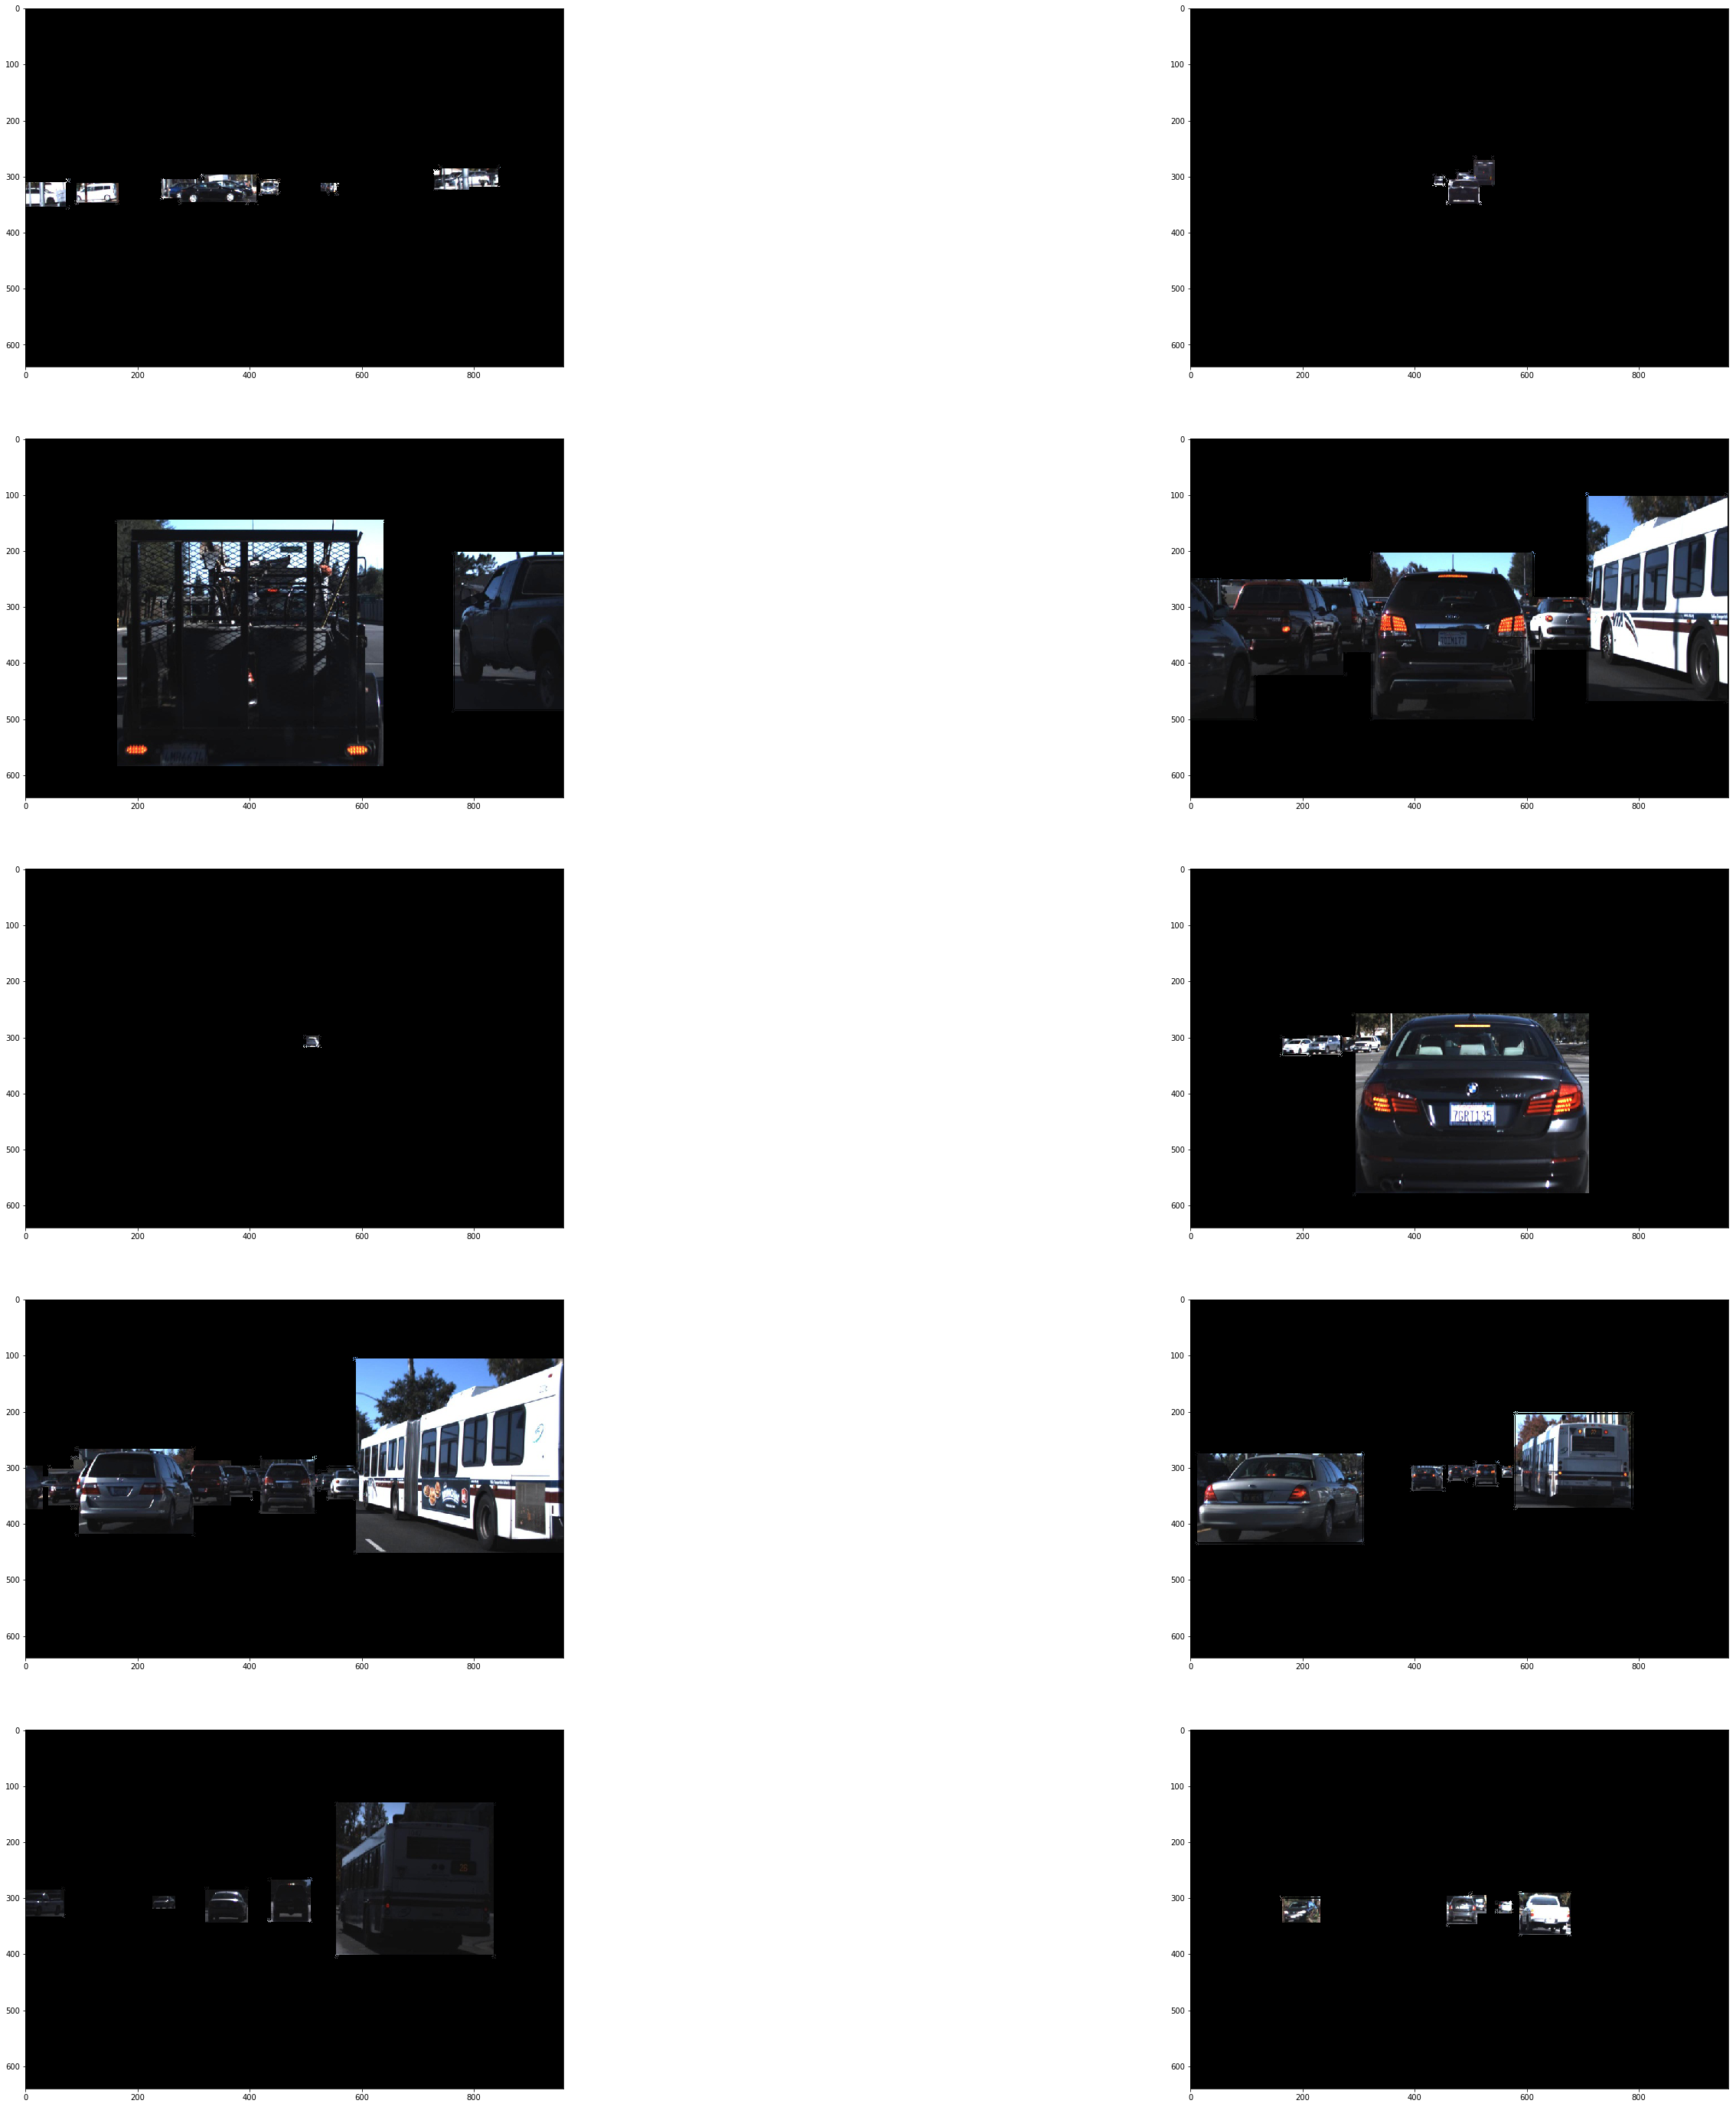

In [5]:
# Select 10 random examples
idx_list = np.random.randint(low = 0, high = paths.shape[0], size=5 * 2)

plt.figure(1, figsize=(50, 50))
for i, idx in enumerate(idx_list):
    plt.subplot(5, 2, i + 1)
    temp(*paths[idx].split("!"))

## Visualize bounding boxes

In [6]:
def plot_bbox(image_path: str, df: pd.DataFrame) -> None:
    image = read_image(image_path)
    df = get_relevant_frames(image_path, df)
    boxes = get_boxes(df)
    
    for box in boxes:
        image = draw_bbox(image, box.left_top, box.right_bot, color=(0, 255, 0), thickness=3)
    
    plt.imshow(image)

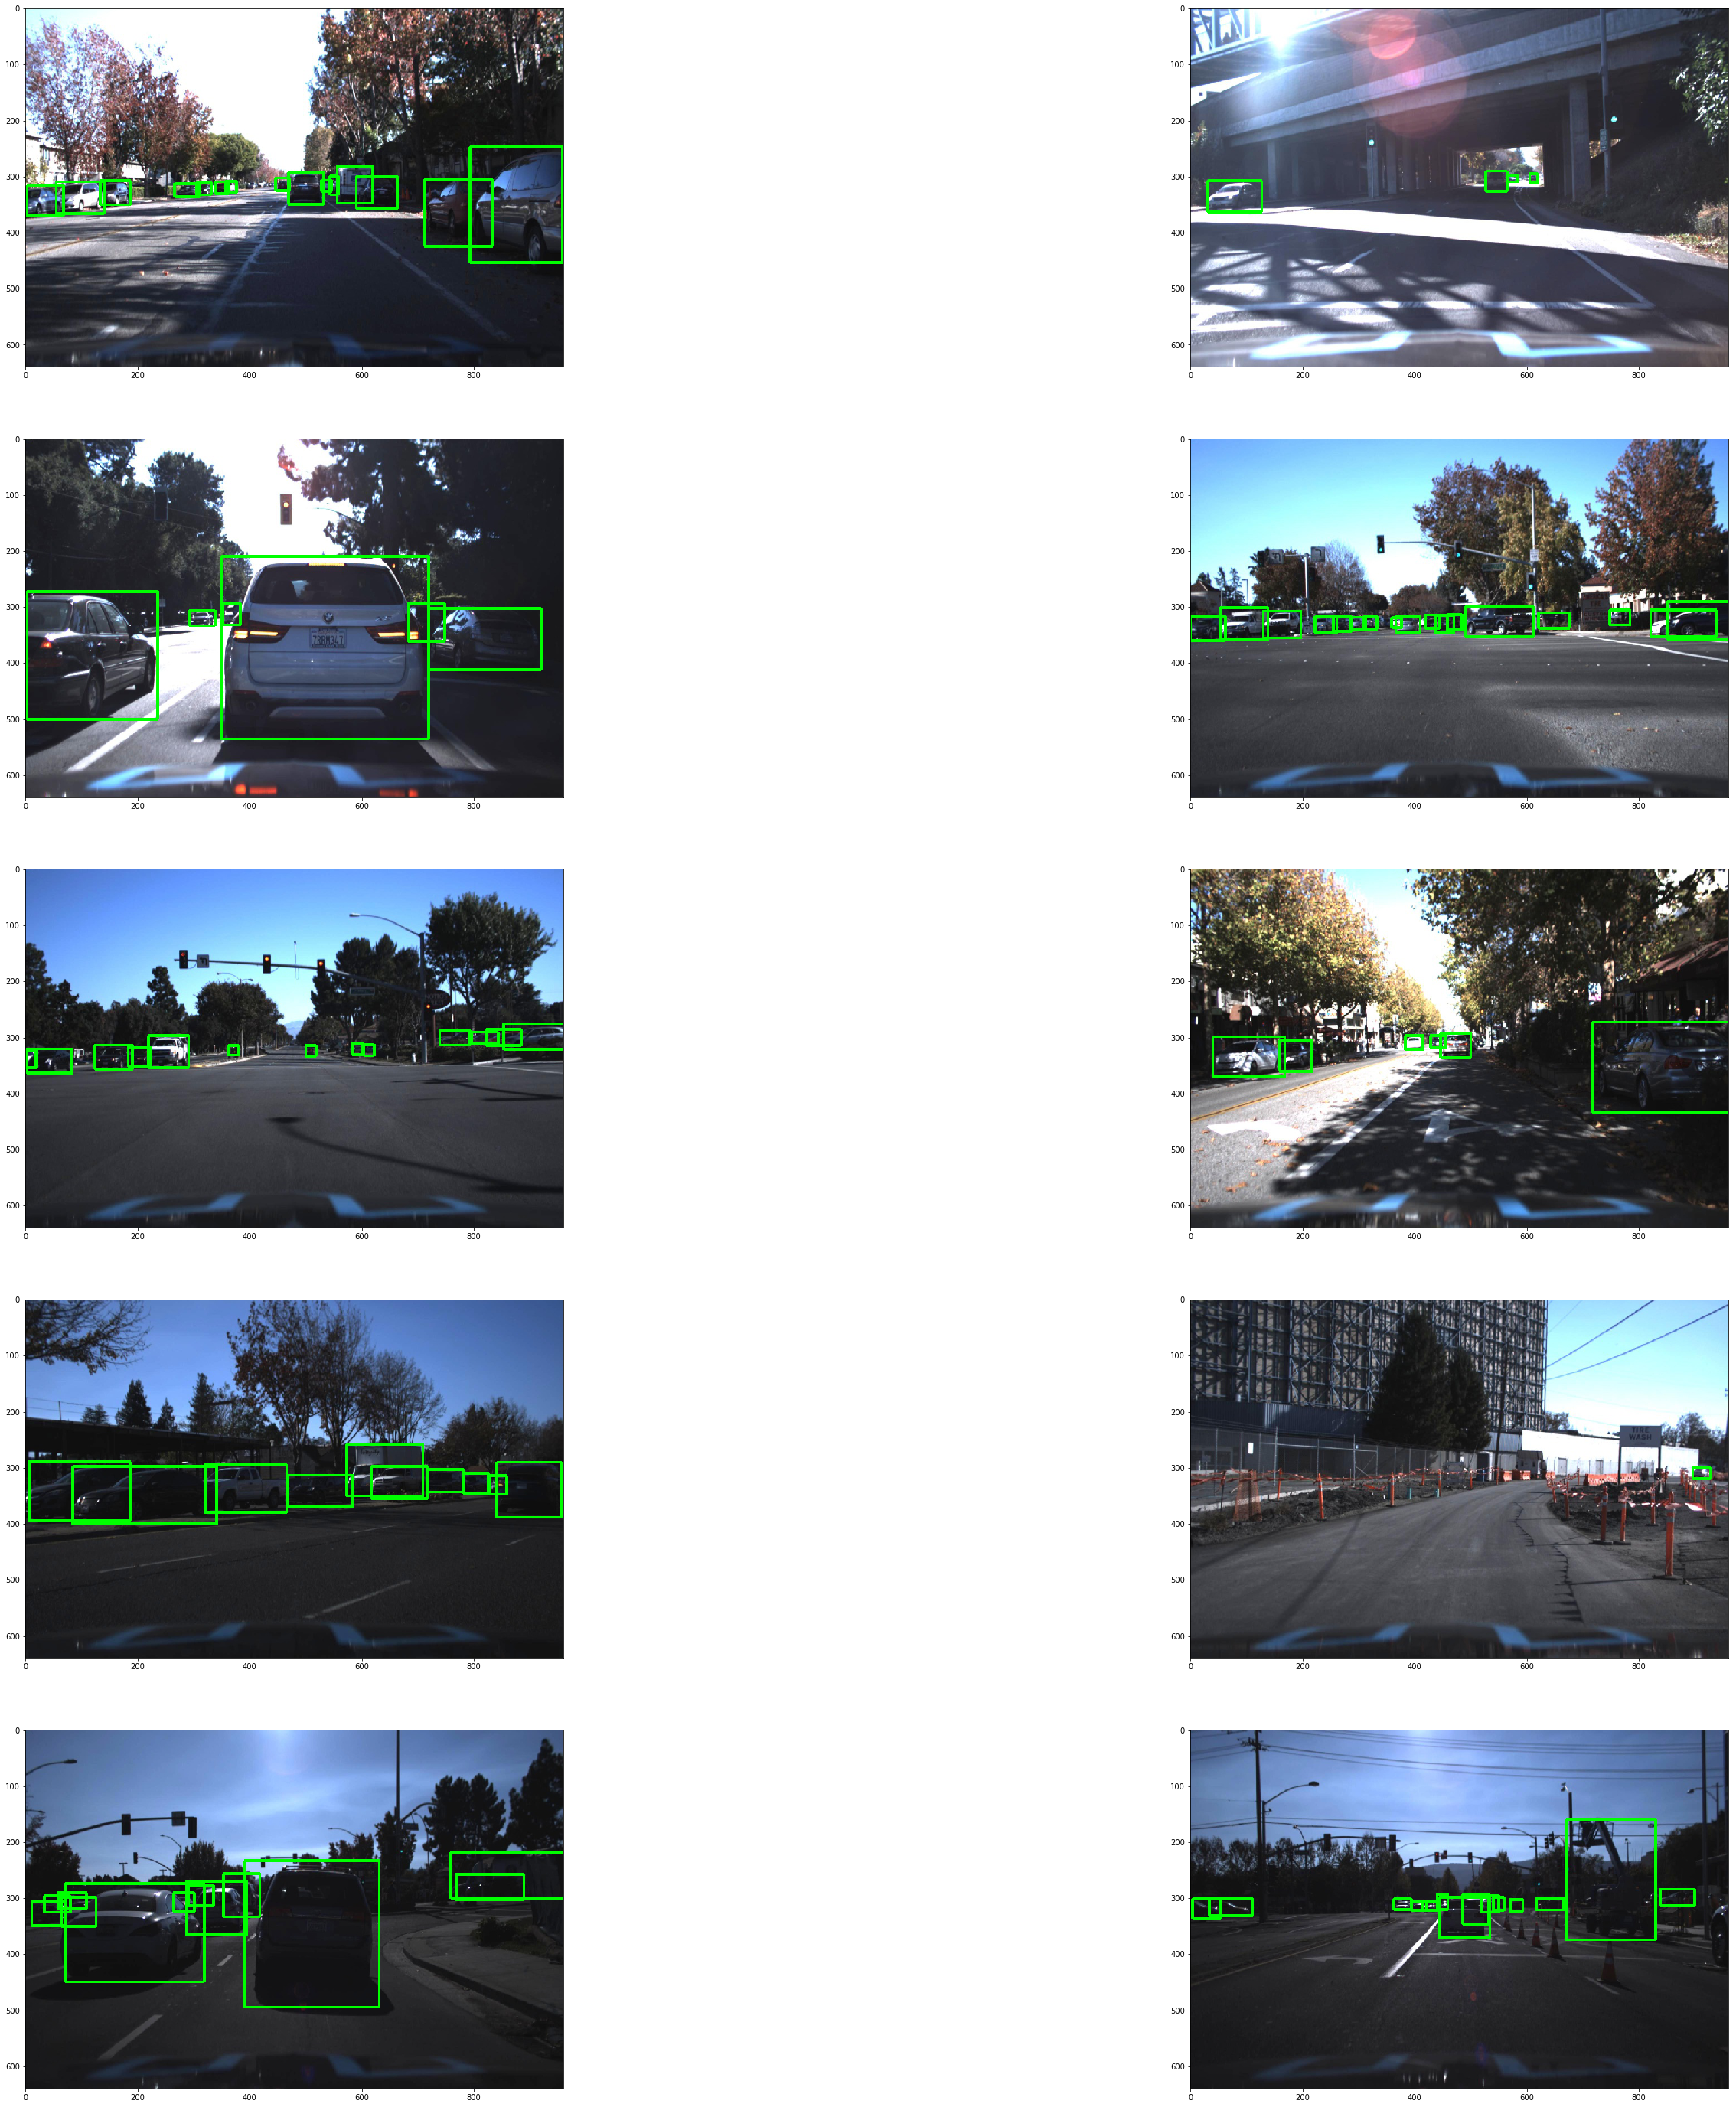

In [7]:
# Select 10 random examples
idx_list = np.random.randint(low = 0, high = paths.shape[0], size=5 * 2)

plt.figure(1, figsize=(50, 50))
for i, idx in enumerate(idx_list):
    plt.subplot(5, 2, i + 1)
    plot_bbox(paths[idx].split("!")[0], labels)

# Split Label into train.csv and test.csv

In [8]:
# Extract 
image_paths = labels["Frame"].unique()
np.random.shuffle(image_paths)
split_idx = int(image_paths.shape[0] * 0.75)

print("train index 0 ~ {} (size: {})".format(split_idx - 1, split_idx))
print("test index {} ~ {} (size: {})".format(split_idx,
                                             image_paths.shape[0] - 1, image_paths.shape[0] - split_idx))

train index 0 ~ 6908 (size: 6909)
test index 6909 ~ 9211 (size: 2303)


In [9]:
train_paths = image_paths[:split_idx]
test_paths = image_paths[split_idx:]

train_paths.shape, test_paths.shape

((6909,), (2303,))

In [10]:
train_csv = labels[labels['Frame'].isin(train_paths)].reset_index(drop=True)
test_csv = labels[labels['Frame'].isin(test_paths)].reset_index(drop=True)

In [11]:
assert train_csv["Frame"].unique().shape[0] == train_paths.shape[0]
assert test_csv["Frame"].unique().shape[0] == test_paths.shape[0]

In [12]:
# only save these two columns
columns = ["Frame", "Mask"]

In [13]:
train_csv[columns].to_csv("train.csv", index=False, header=False)
test_csv[columns].to_csv("test.csv", index=False, header=False)